This script attempts to remove seasonality using FFT by zeroing out the relevant frequencies. An approach of using low-pass and high-pass filters was tested as well.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
from scipy.fft import rfft, rfftfreq, irfft
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
def bair_data_read_in(site_dir:str):
    df_lst = []
    for file in os.listdir(site_dir):
        try:
            df = pd.read_csv(rf'{site_dir}/{file}', header=1)
            df['time'] = pd.to_datetime(df['time'], unit='s')
            df['time'] = df['time'].dt.round('min')
            df_lst.append(df)
        except:
            pass
    data = pd.concat(df_lst)
    data = data.sort_values('time')
    try:
        data = data.rename(columns={'wsp_avg_ms': 'wsp', 'wdr_avg': 'wdr'})
    except AttributeError:
        pass
    if 'met' in site_dir:
        data = data[['time', 'wsp', 'wdr', 'temp_f']]
    else:
        data = data[['time', 'isoprene']]
    return data

In [3]:
isoprene = bair_data_read_in(r'/Users/gabegreenberg/Boulder_AIR/BoulderAIR_data/LUR/voc')
print(isoprene)

                    time  isoprene
0    2020-02-01 00:42:00   0.01731
1    2020-02-01 02:06:00   0.01313
2    2020-02-01 03:31:00   0.01731
3    2020-02-01 04:55:00   0.01851
4    2020-02-01 06:20:00   0.01373
...                  ...       ...
1023 2025-02-19 00:05:00   0.00504
1024 2025-02-19 01:05:00   0.00504
1025 2025-02-19 02:05:00   0.00504
1026 2025-02-19 03:05:00   0.00504
1027 2025-02-19 04:05:00   0.00504

[40055 rows x 2 columns]


In [4]:
isoprene['time'] = isoprene['time'].dt.round('H')
isoprene.set_index('time', inplace=True)
isoprene = isoprene.resample('H').mean()
isoprene['isoprene'] = isoprene['isoprene'].interpolate(method='linear') 
hourly_isoprene = isoprene.reset_index()

/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_43680/734527379.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  isoprene['time'] = isoprene['time'].dt.round('H')
/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_43680/734527379.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  isoprene = isoprene.resample('H').mean()


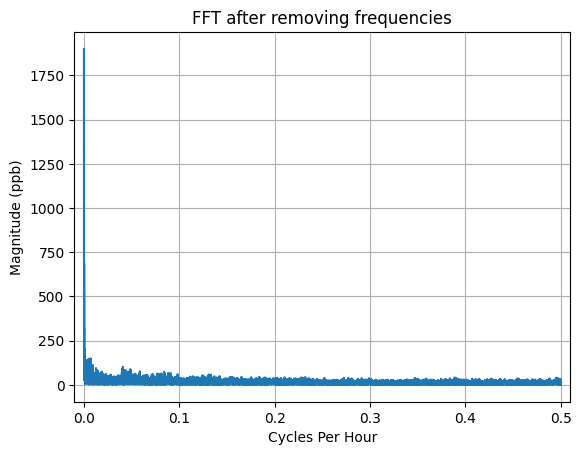

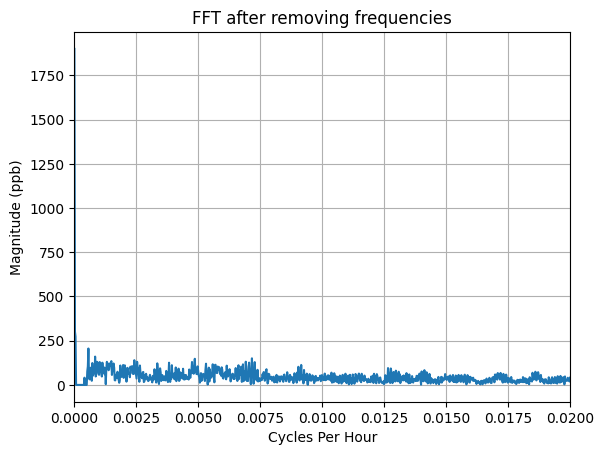

[0.01589377 0.01458529 0.0161461  ... 0.00422718 0.00387647 0.00259445]


In [5]:
def remove_seasonal_frequencies(isoprene, f_range: float, frequency: float, fig_scale=(-.01, .51)):
    '''
    This function converts isoprene into the frequency domain using a FFT then zero's out frequencies of seasonal cycles in a narrow band 
    (it also removes harmonics of the signal), 
    before plotting the data in the frequency domain then inverting the transfom.

    Args:
        isoprene: the isoprene column from a df
        f_range: frequency range to be removed (1/2 the width of the band being removed)
        frequency: the frequcy to be removed in the center of band (in hours)
        fig_scale: a parameter used for cropping the x-axis of the fft resolt plot

    Returns: an array of isoprene in the time domain with the seasoanl signal removed.
    '''
    #doing the forier transform
    n = len(isoprene)
    samp_f = 1  
    fft_iso = rfft(isoprene)
    fft_time = rfftfreq(n, 1 / samp_f)

    # this gets the harmonics to zero them out as well
    target_freqs = np.array([n / frequency for n in range(1, int(n / frequency))])
    filt_isoprene = fft_iso.copy()

    # selectivly zeroing out the indecies of the frequencies I want to remove
    for ff in target_freqs:
        indexes_to_zero = np.where((fft_time >= ff - f_range) & (fft_time <= ff + f_range))[0]
        filt_isoprene[indexes_to_zero] = 0

    plt.plot(fft_time, np.abs(filt_isoprene))
    plt.xlim(fig_scale)
    plt.grid()
    plt.title("FFT after removing frequencies")
    plt.xlabel('Cycles Per Hour')
    plt.ylabel('Magnitude (ppb)')
    plt.show()

    filtered_sig = irfft(filt_isoprene)
    return filtered_sig

# the yearly signal removes the diurnal signal and the dirunal signal removes the yearly signal
yearly_signal = remove_seasonal_frequencies(isoprene['isoprene'], .0004, 24)
dirunal_signal = remove_seasonal_frequencies(isoprene['isoprene'], .00005, 8760, (0, 0.02))
print(yearly_signal)


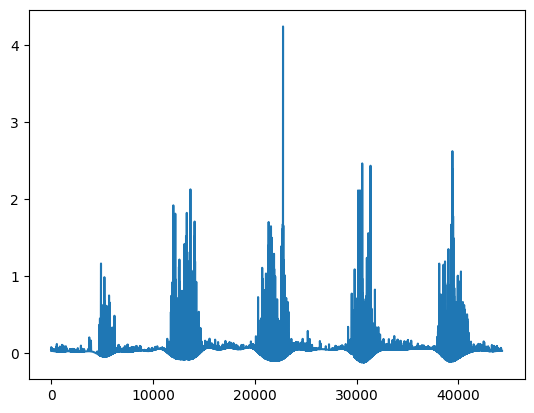

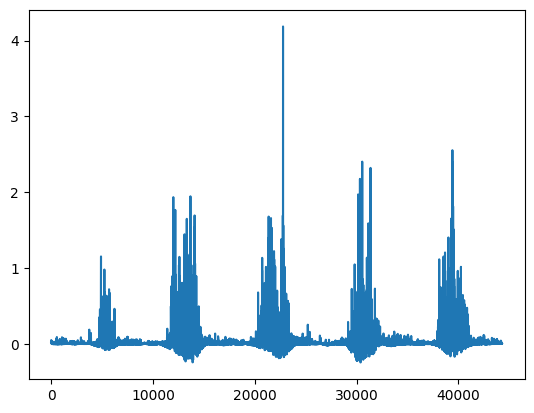

In [6]:
plt.plot(dirunal_signal)
plt.show()

plt.plot(yearly_signal)
plt.show()

# this method clearly causes negative artificating whichh is why I decided to try using a low and highpass filters

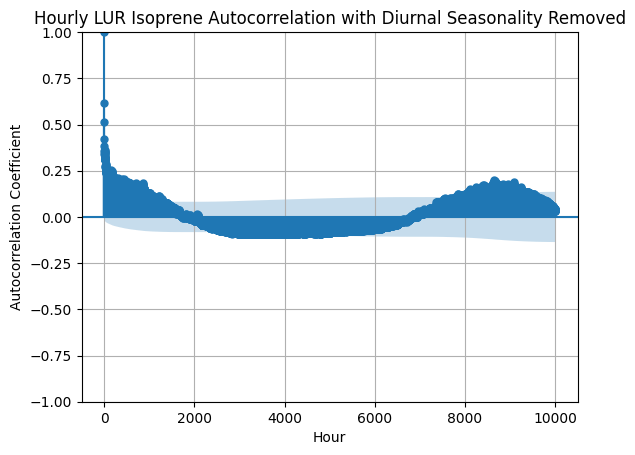

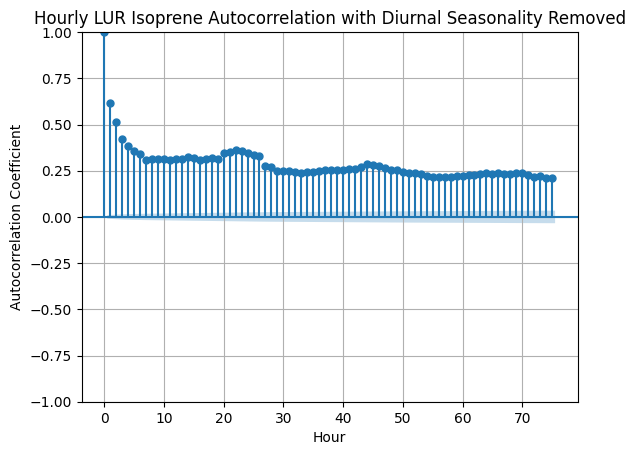

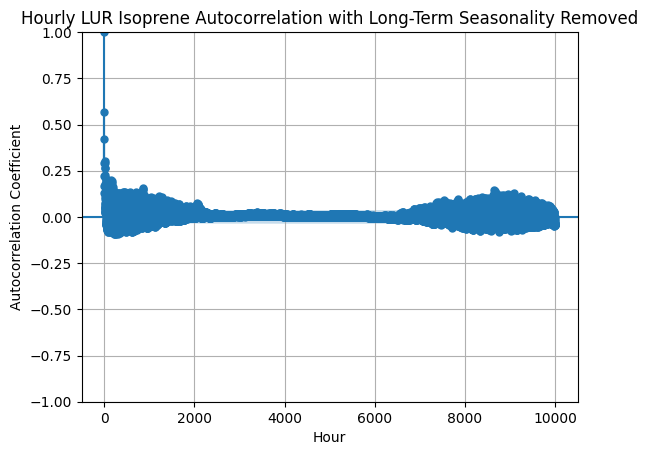

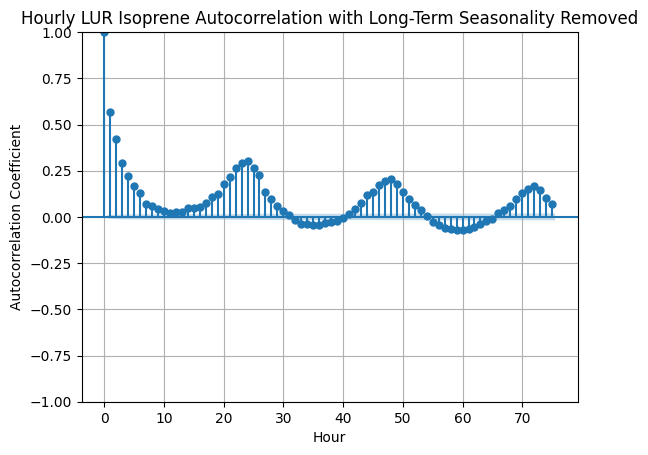

In [7]:
# does an ok job of removing the diurnal signal
plot_acf(yearly_signal, lags=10000)  
plt.title('Hourly LUR Isoprene Autocorrelation with Diurnal Seasonality Removed')
plt.xlabel('Hour')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()
plt.show()

plot_acf(yearly_signal, lags=75)  
plt.title('Hourly LUR Isoprene Autocorrelation with Diurnal Seasonality Removed')
plt.xlabel('Hour')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()
plt.show()

###

# does an ok job of removing the yearly signal although seems like there still a lot more variance during isoprene season
plot_acf(dirunal_signal, lags=10000)  
plt.title('Hourly LUR Isoprene Autocorrelation with Long-Term Seasonality Removed')
plt.xlabel('Hour')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()
plt.show()

plot_acf(dirunal_signal, lags=75)  
plt.title('Hourly LUR Isoprene Autocorrelation with Long-Term Seasonality Removed')
plt.xlabel('Hour')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()
plt.show()

